In [1]:
import torch
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
#from sklearn.preprocessing import MinMaxScaler


In [2]:
def MinMaxScale(data):
    numerator = data - min(data)
    denominator = max(data) - min(data)
    normalization = numerator / (denominator + 1e-7)
    return normalization

def getStartEnd(startDate, endDate, time): #특정 계절에 대한 데이터만 추출할 때 사용
    start, end = 1, 1
    for idx in range(len(time)):  
        #print(time[idx])
        if time[idx] == startDate: 
            start = idx
        if time[idx] == endDate:
            end = idx
    return [start, end]


In [8]:
time = pd.read_excel('/Users/gyuhuikwon/Desktop/data/edition/평균수온2018.xlsx')
time = time['시간'].values

raw_df = pd.read_excel('/Users/gyuhuikwon/Desktop/data/edition/CLM_이산화탄소2018.xlsx')
dataset = raw_df['평균이산화탄소배경대기농도(ppm)'].values
dataset_ = MinMaxScale(dataset)

label = pd.read_excel('/Users/gyuhuikwon/Desktop/data/edition/평균수온2018.xlsx')
label = label['평균수온(°∆C)'].values
label_ = MinMaxScale(label)

def seq_data(x, y, sequence_length):
    x_seq, y_seq = [], []
    
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i: i+sequence_length])
        y_seq.append(y[i+sequence_length])
    x_seq, y_seq = np.array(x_seq), np.array(y_seq)
    
    return torch.Tensor(x_seq).float(), torch.Tensor(y_seq).float().view([-1,1])

print("len(dataset) / len(label) : ", len(dataset), '/', len(label))

len(dataset) / len(label) :  365 / 365


In [18]:
split = 300
sequence_length = 5

x_seq, y_seq = seq_data(dataset_, label_, sequence_length)
#print(x_seq, dataset)
#print(y_seq[0:10], label[0:10])
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

#print(x_seq.size()) #300행*5열
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([300, 5]) torch.Size([300, 1])
torch.Size([60, 5]) torch.Size([60, 1])


In [15]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)
#train_loader : [tensor([[x 5개씩]*20행]), tensor([[y 5개씩]*20행])] 묶음이 15개 

train_list = []
for data in train_loader:
    x, y = data
    #print(x.size()[0])
    #train_list.append(x) 
print(x.shape) #2차원
#print(train)
#print((train_list)) #(20행*5열)*15개 텐서
#print(len(train_list[0][0][0]), len(train_list[0][0]), len(train_list), x_train_seq.size())

torch.Size([20, 5])


In [7]:
input_size = x_seq.size() #1차원의 입력 벡터(데이터종류1개)
num_layers = 1
hidden_size = 5 #rnn의 대표적인 하이퍼파라미터
print(input_size)

torch.Size([360, 5])


In [550]:
class RNN_1_1(nn.Module): #파이토치의 nn.RNN()은 기본 3차원 텐서를 입력받음

    def __init__(self, input_size, hidden_size, sequence_length, num_layers, batch_size):
        super(RNN_1_1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        #output_size = 1
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.ReLU())

    def forward(self, x): #구현한 .rnn 셀과 .fc(출력층)을 연결
        print(x.size()) #20행 5열=(20,5)
        inputs = x.unfold(dimension=0, size = self.sequence_length, step = 1) #행 방향 #(5,20,1)
        print(inputs.size()) #(16,5,5)
        h0 = torch.zeros(self.num_layers, inputs.size()[0], self.hidden_size) # 초기 hidden state.size(1,16,5). #len(h0)=num_layers
        print(h0.size()) #(1,16,5)
        out, _ = self.rnn(inputs, h0) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state를 반환한다.
        print(out.size()) #(16,5,5)
        out = out.reshape(out.shape[0],-1) # many to one 전략 # size(16, 25)
        out = self.fc(out)
        return out
    
model = RNN_1_1(input_size=input_size,
        hidden_size=hidden_size,
        sequence_length=sequence_length,
        num_layers=num_layers, batch_size=batch_size)
       

In [553]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr)

In [545]:
a = torch.FloatTensor([[1,2],[3,4],[5,6],[7,8]])
print(a.size()[0]) #(4,2)의 0번쨰 숫자
print(a.size(0)) #0차원 사이즈
print(a.dim()) #텐서 차원(size 개수 2개)
b = a.unfold(dimension=0, size=2, step=1)
print(b)
print(b.size()) #size=1 (4,2,1) / size=2 (3,2,2)
c= b.reshape(b.shape[0],-1)
print(c)
print(c.size())

4
4
2
tensor([[[1., 3.],
         [2., 4.]],

        [[3., 5.],
         [4., 6.]],

        [[5., 7.],
         [6., 8.]]])
torch.Size([3, 2, 2])
tensor([[1., 3., 2., 4.],
        [3., 5., 4., 6.],
        [5., 7., 6., 8.]])
torch.Size([3, 4])


In [554]:
loss_graph = [] # 그래프 그릴 목적인 loss

for epoch in tqdm(range(num_epochs)): #총 10번
  total_loss = 0

  for data in train_loader: #15번 for문

    seq, target = data # 배치 데이터.
    out = model(seq)# 모델에 넣고,
    #print(len(out))
    loss = criterion(out, target) # output 가지고 loss 구하고,
    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    
    total_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(total_loss / len(train_loader)) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  
  if epoch % 20 == 0:
    print(f"epoch: {epoch} loss: {loss.item():.4f}")

100%|██████████| 10/10 [00:00<00:00, 76.86it/s]

torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
torch.Size([16, 5, 5])
torch.Size([1, 16, 5])
torch.Size([16, 5, 5])
torch.Size([20, 5])
t

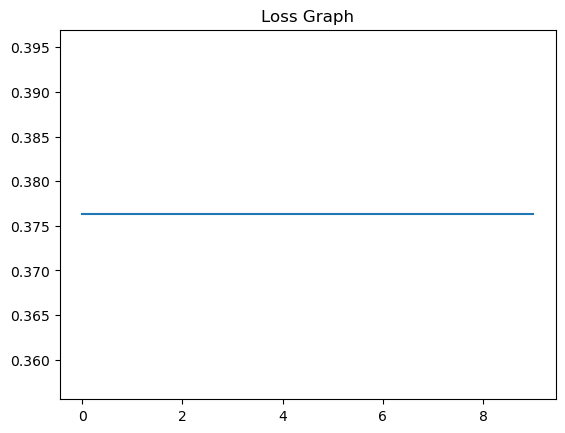

In [555]:
plt.title('Loss Graph')
plt.plot(loss_graph)
plt.show()


In [556]:
for data in train_loader:
    seq, target = data
    model.fit(data)
    y_pred = model.predict()
    y_test = 

SyntaxError: invalid syntax (3102472087.py, line 5)

20
16
20
32
20
48
20
64
20
80
20
96
20
112
20
128
20
144
20
160
20
176
20
192
20
208
20
224
20
240


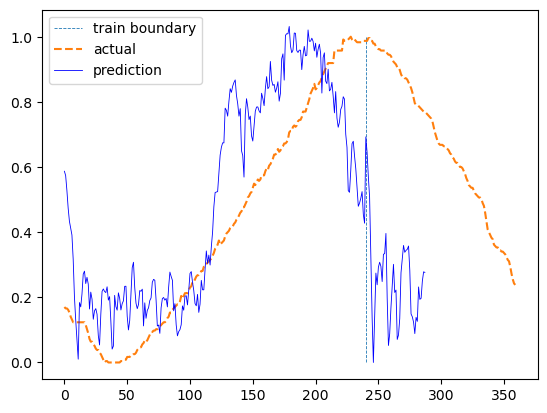

In [397]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader: #20개(1개 batch)를 15번 돌림
      seq, target = data
      out = model(seq) #16개(1개 batch) 15번 뽑아냄
      train_pred += out.numpy().tolist()
      print(len(train_pred))
    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.numpy().tolist()
      
  total = train_pred + test_pred
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)
  #print(len(total))
  #prediction = 
  #print(f"prediction:{prediction.item()} real:{real}")
  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, label_[sequence_length:])

240
48


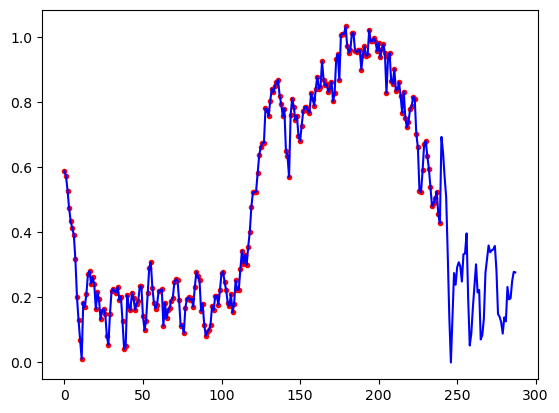

In [391]:

with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.numpy().tolist()
    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.numpy().tolist()
      total = train_pred + test_pred
print(len(train_pred))
print(len(test_pred))
plt.plot(train_pred, '.r')
#plt.plot(test_pred)
plt.plot(total, 'b')